# Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import genieclust
import time
from sklearn.preprocessing import MinMaxScaler


## Loading & preprocessing

In [135]:
df_original = pd.read_csv('./mnist_train.csv',)
label_original = df_original['5']

#df_original = df_original.sample(n=1000, random_state=123)
df_original = df_original[:2000]
label = label_original[:2000]
df = df_original.drop(columns='5')


In [136]:
# resizing the images to 20*20 (from 28*28) pixle improve computation cost
df_arr = df.to_numpy()

from skimage.transform import resize
df_resized = [resize(x, (20,20)) for x in df_arr]


In [137]:
#recomposing to pd df
df_resized = [np.array(x).flatten() for x in df_resized]

#df_selected = df_resized[:2000]
df = pd.DataFrame(df_resized)
#np.array(df_resized).shape
df.shape

#fit to code
df_scaled = df


## EDA & PCA

<AxesSubplot:xlabel='PCA 1', ylabel='PCA 2'>

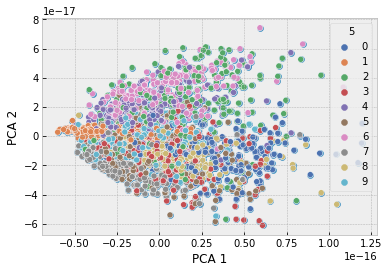

In [41]:
# Applying simple 2 component PCA
import seaborn as sb
from sklearn.decomposition import PCA

pca = PCA(n_components = 2).fit_transform(df)

pca_dim1 = np.array([row[0] for row in pca])
pca_dim2 = np.array([row[1] for row in pca])

plt.scatter(x=pca_dim1, y=pca_dim2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

#plt.title("Beans 2D PCA")
#plt.show()

sb.scatterplot(data=df_original, x=pca_dim1, y=pca_dim2,
               hue='5', palette="deep")


In [ ]:
# Add a timer for each of the methods, just record time for the block that generates the dendrogram
start_time = time.time()
elapsed_time = time.time() - start_time
elapsed_time

## Single-linkage/SLINK

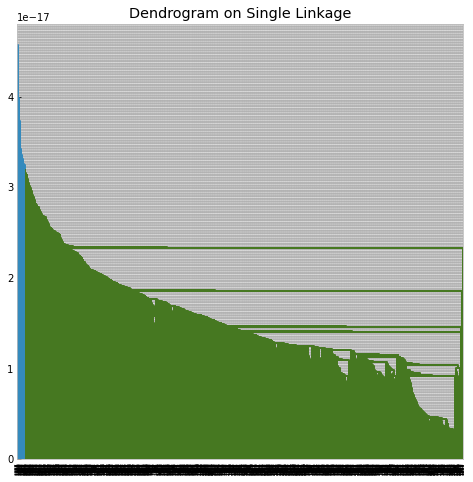

[1]
48.81478309631348


In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram
start_time = time.time()

plt.style.use("bmh")
plt.figure(figsize =(8, 8))
plt.title('Dendrogram on Single Linkage')
#single_linkage = linkage(df_scaled, method ='single',metric='hamming')
single_linkage = linkage(df_scaled, method='single')
Dendrogram = dendrogram(single_linkage)

# specifying horizontal threshold line
#plt.axhline(y = 1.72, color = 'yellow', linestyle = '-')
plt.show()

# threshold appears to be 1.72 because the longest, thus an optimal number of clusters could be 13 clusters
from scipy.cluster.hierarchy import fcluster
print(np.unique(fcluster(single_linkage, t=1.72, criterion='distance')))

elapsed_time = time.time() - start_time
print(elapsed_time)


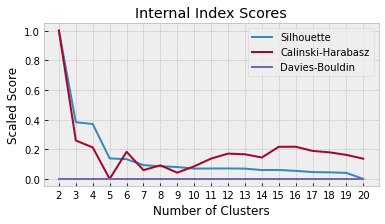

In [43]:
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
# xie-beni?
# SSE elbow? - don't have true values...


silhouette_coefficients = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

test_range = range(2, 21)

for k in test_range:
    SLINK = AgglomerativeClustering(n_clusters=k, linkage="single")
    SLINK.fit(df_scaled)
    ##Silhouette Score
    silhouette = silhouette_score(df_scaled, SLINK.labels_)
    silhouette_coefficients.append(silhouette)
    ##Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(df_scaled, SLINK.labels_)
    calinski_harabasz_scores.append(calinski_harabasz)
    ##Davies-Bouldin Score
    davies_bouldin = davies_bouldin_score(df_scaled, SLINK.labels_)
    davies_bouldin_scores.append(davies_bouldin)

#scaled to same range to plot on a single graph
score_scaler = MinMaxScaler(feature_range=(0, 1))

silhouette_coefficients_scaled = score_scaler.fit_transform(
    np.array(silhouette_coefficients).reshape(-1, 1))
calinski_harabasz_scores_scaled = score_scaler.fit_transform(
    np.array(calinski_harabasz_scores).reshape(-1, 1))
davies_bouldin_scores_scaled = score_scaler.fit_transform(
    np.array(davies_bouldin_scores).reshape(-1, 1))

#plot all three
plt.figure(figsize=(6, 3))
plt.title("Internal Index Scores")
plt.plot(test_range, silhouette_coefficients_scaled, label='Silhouette')
plt.plot(test_range, calinski_harabasz_scores_scaled,
         label='Calinski-Harabasz')
plt.plot(test_range, davies_bouldin_scores_scaled, label='Davies-Bouldin')
plt.xticks(test_range)
plt.legend()
## if labelled, add a vertical line for the true number of clusters
plt.xlabel("Number of Clusters")
plt.ylabel("Scaled Score")
plt.show()



## Ward's Linkage


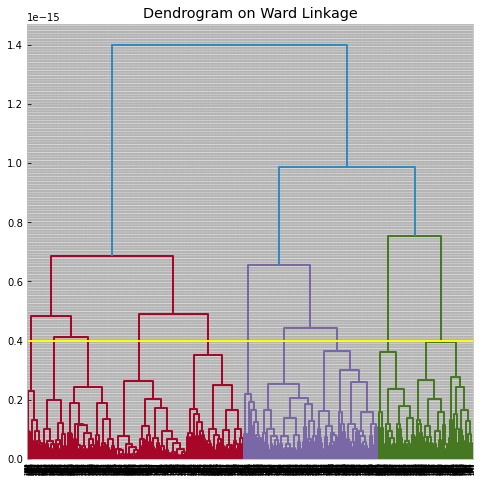

[ 1  2  3  4  5  6  7  8  9 10]


96.67568945884705

In [138]:
start_time = time.time()

plt.style.use("bmh")
plt.figure(figsize =(8, 8))
plt.title('Dendrogram on Ward Linkage')
ward_linkage = linkage(df_scaled, method ='ward')
Dendrogram = dendrogram(ward_linkage)

# specifying horizontal threshold line
plt.axhline(y = 0.0000000000000004, color = 'yellow', linestyle = '-')
plt.show()

# threshold appears to be 50 because the longest, thus an optimal number of clusters could be 4 clusters

print(np.unique(fcluster(ward_linkage, t=0.0000000000000004, criterion='distance')))

end_time = time.time() - start_time
end_time

In [183]:
#WARD = AgglomerativeClustering(n_clusters=10, linkage="ward")
#WARD.fit(df_scaled)
#labels = WARD.labels_
GENIE = genieclust.Genie(n_clusters=10, gini_threshold=0.2)
labels = GENIE.fit_predict(df_scaled)


df_new = pd.DataFrame(label_original.copy())
df_new = df_new[:2000]
df_new
df_new['GENIE'] = labels


In [184]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(df_new[df_new['GENIE'] == 0].groupby('5').count())
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(df_new[df_new['GENIE'] == 1].groupby('5').count())

for i in range(10):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df_new[df_new['GENIE'] == i].groupby('5').count())


   GENIE
5       
0    101
1    218
2     67
3     75
4      3
5     93
6     49
7      9
8     72
9     11
   GENIE
5       
2     26
3      2
4    147
5      5
6      2
7     32
8      1
9     26
   GENIE
5       
3      8
4     30
5      3
7      9
8      1
9     43
   GENIE
5       
1      1
2     81
3      1
4      2
5      5
6    146
8      1
   GENIE
5       
0     28
2      3
3     37
5     31
7      3
8     81
9      2
   GENIE
5       
0     15
2     12
3     46
5     24
6      2
8      2
9      2
   GENIE
5       
3      3
5      7
7     76
   GENIE
5       
1      1
2      3
3      3
4     32
5      1
6      1
7     15
8      3
9    124
   GENIE
5       
2      1
3      2
5      4
7     79
8      1
9      2
   GENIE
5       
0     47
2      5
3     14
5      7
7      1
8     10


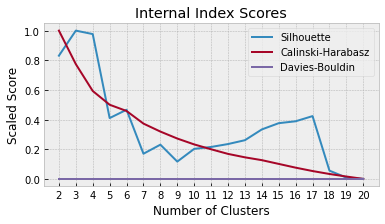

In [86]:
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
# xie-beni?
# SSE elbow? - don't have true values...


silhouette_coefficients = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

test_range = range(2, 21)

for k in test_range:
    WARD = AgglomerativeClustering(n_clusters=k, linkage="ward")
    WARD.fit(df_scaled)
    ##Silhouette Score
    silhouette = silhouette_score(df_scaled, WARD.labels_)
    silhouette_coefficients.append(silhouette)
    ##Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(df_scaled, WARD.labels_)
    calinski_harabasz_scores.append(calinski_harabasz)
    ##Davies-Bouldin Score
    davies_bouldin = davies_bouldin_score(df_scaled, WARD.labels_)
    davies_bouldin_scores.append(davies_bouldin)


#scaled to same range to plot on a single graph
score_scaler = MinMaxScaler(feature_range=(0, 1))

silhouette_coefficients_scaled = score_scaler.fit_transform(
    np.array(silhouette_coefficients).reshape(-1, 1))
calinski_harabasz_scores_scaled = score_scaler.fit_transform(
    np.array(calinski_harabasz_scores).reshape(-1, 1))
davies_bouldin_scores_scaled = score_scaler.fit_transform(
    np.array(davies_bouldin_scores).reshape(-1, 1))

#plot all three
plt.figure(figsize=(6, 3))
plt.title("Internal Index Scores")
plt.plot(test_range, silhouette_coefficients_scaled, label='Silhouette')
plt.plot(test_range, calinski_harabasz_scores_scaled,
         label='Calinski-Harabasz')
plt.plot(test_range, davies_bouldin_scores_scaled, label='Davies-Bouldin')
plt.xticks(test_range)
plt.legend()
## if labelled, add a vertical line for the true number of clusters
plt.xlabel("Number of Clusters")
plt.ylabel("Scaled Score")
plt.show()


## GENIE

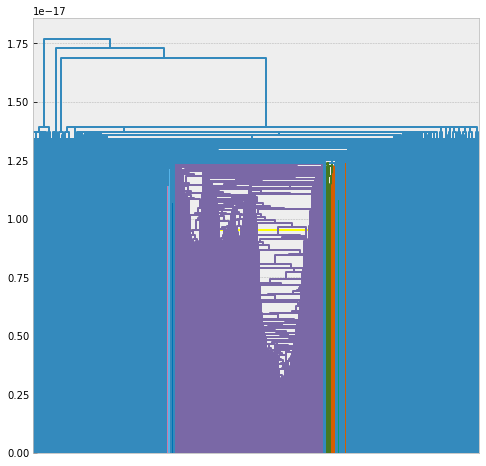

[   1    2    3 ... 1515 1516 1517]
0.7286121845245361


In [150]:
##threshold 
from scipy.cluster.hierarchy import linkage, dendrogram
import genieclust

start_time = time.time()

plt.style.use("bmh")
plt.figure(figsize =(8, 8))

# specifying horizontal threshold line
plt.axhline(y=0.0000000000000000095, color='yellow', linestyle='-')

# https://genieclust.gagolewski.com/weave/basics.html#dendrograms
g = genieclust.Genie(compute_full_tree=True,gini_threshold=0.5)
g.fit(df_scaled)
linkage_matrix = np.column_stack([g.children_, g.distances_, g.counts_])
dendrogram(linkage_matrix,
    show_leaf_counts=False, no_labels=True)
plt.show()

from scipy.cluster.hierarchy import fcluster
# threshold appears to be 1.25 because the longest, thus an optimal number of clusters could be 10 clusters
#labels = fcluster(linkage_matrix, t=0.0000000000000000075, criterion='distance')
labels = fcluster(linkage_matrix, t=0.0000000000000000095,
                  criterion='distance')
print(np.unique(labels))

elapsed_time = time.time() - start_time
print(elapsed_time)


In [170]:
GENIE = genieclust.Genie(n_clusters=10, gini_threshold=0.2)
labels = GENIE.fit_predict(df_scaled)

df_new = pd.DataFrame(label_original.copy())
df_new = df_new[:2000]
df_new
df_new['GENIE'] = labels


In [171]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_new[df_new['GENIE'] == 0].groupby('5').count())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_new[df_new['GENIE'] == 1].groupby('5').count())


   GENIE
5       
0    101
1    218
2     67
3     75
4      3
5     93
6     49
7      9
8     72
9     11
   GENIE
5       
2     26
3      2
4    147
5      5
6      2
7     32
8      1
9     26


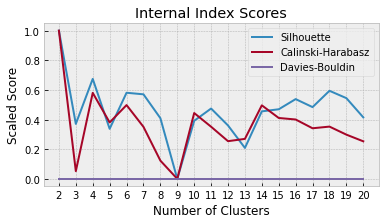

In [81]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

silhouette_coefficients = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

test_range = range(2, 21)

for k in test_range:
    GENIE = genieclust.Genie(n_clusters=k,gini_threshold=0.2)
    labels = GENIE.fit_predict(df_scaled)
    ##Silhouette Score
    silhouette = silhouette_score(df_scaled, labels)
    silhouette_coefficients.append(silhouette)
    ##Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(df_scaled, labels)
    calinski_harabasz_scores.append(calinski_harabasz)
    ##Davies-Bouldin Score
    davies_bouldin = davies_bouldin_score(df_scaled, labels)
    davies_bouldin_scores.append(davies_bouldin)


#scaled to same range to plot on a single graph
score_scaler = MinMaxScaler(feature_range=(0, 1))

silhouette_coefficients_scaled = score_scaler.fit_transform(
    np.array(silhouette_coefficients).reshape(-1, 1))
calinski_harabasz_scores_scaled = score_scaler.fit_transform(
    np.array(calinski_harabasz_scores).reshape(-1, 1))
davies_bouldin_scores_scaled = score_scaler.fit_transform(
    np.array(davies_bouldin_scores).reshape(-1, 1))

#plot all three
plt.figure(figsize=(6, 3))
plt.title("Internal Index Scores")
plt.plot(test_range, silhouette_coefficients_scaled, label='Silhouette')
plt.plot(test_range, calinski_harabasz_scores_scaled,
         label='Calinski-Harabasz')
plt.plot(test_range, davies_bouldin_scores_scaled, label='Davies-Bouldin')
plt.xticks(test_range)
plt.legend()
## if labelled, add a vertical line for the true number of clusters
plt.xlabel("Number of Clusters")
plt.ylabel("Scaled Score")
plt.show()


## Centroid linkage

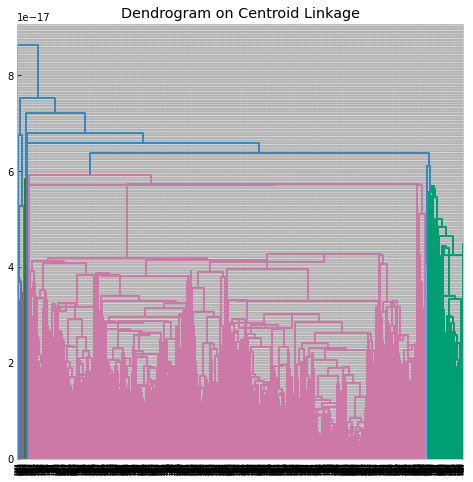

44.86955261230469

In [87]:
start_time = time.time()

plt.style.use("bmh")
plt.figure(figsize =(8, 8))
plt.title('Dendrogram on Centroid Linkage')
centroid_linkage = linkage(df_scaled, method ='centroid')
Dendrogram = dendrogram(centroid_linkage)

# specifying horizontal threshold line
#plt.axhline(y = 3.5, color = 'yellow', linestyle = '-')
plt.show()

# threshold appears to be 3.5 because the longest, thus an optimal number of clusters could be 4 clusters
#labels = fcluster(centroid_linkage, t=3.5, criterion='distance')
#print(np.unique(labels))

end_time = time.time() - start_time
end_time

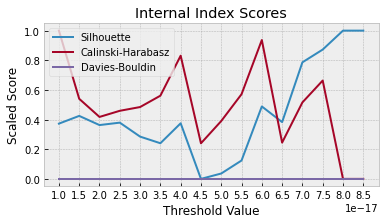

In [88]:
# no AgglomerativeClustering method for centroid

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

num_clusters = []
silhouette_coefficients = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

test_range = np.arange(0.00000000000000001, 0.00000000000000009, 0.000000000000000005)


centroid_linkage = linkage(df_scaled, method ='centroid')

# instead, we will increase with threshold instead of num clusters
# Threshold is maximum inter-cluster distance allowed
for thresh in test_range:
    labels = fcluster(centroid_linkage, t=thresh, criterion='distance')
    ##Silhouette Score
    silhouette = silhouette_score(df_scaled, labels)
    silhouette_coefficients.append(silhouette)
    ##Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(df_scaled, labels)
    calinski_harabasz_scores.append(calinski_harabasz)
    ##Davies-Bouldin Score
    davies_bouldin = davies_bouldin_score(df_scaled, labels)
    davies_bouldin_scores.append(davies_bouldin)
    ##num clusters just in case
    num_clusters.append(np.unique(labels))


#scaled to same range to plot on a single graph
score_scaler = MinMaxScaler(feature_range=(0, 1))

silhouette_coefficients_scaled = score_scaler.fit_transform(
    np.array(silhouette_coefficients).reshape(-1, 1))
calinski_harabasz_scores_scaled = score_scaler.fit_transform(
    np.array(calinski_harabasz_scores).reshape(-1, 1))
davies_bouldin_scores_scaled = score_scaler.fit_transform(
    np.array(davies_bouldin_scores).reshape(-1, 1))

#plot all three
plt.figure(figsize=(6, 3))
plt.title("Internal Index Scores")
plt.plot(test_range, silhouette_coefficients_scaled, label='Silhouette')
plt.plot(test_range, calinski_harabasz_scores_scaled,
         label='Calinski-Harabasz')
plt.plot(test_range, davies_bouldin_scores_scaled, label='Davies-Bouldin')
plt.xticks(test_range)
plt.legend()
## if labelled, add a vertical line for the true number of clusters
plt.xlabel("Threshold Value")
plt.ylabel("Scaled Score")
plt.show()


## Weighted Pair Group Method with Arithmetic Mean (WPGMA)

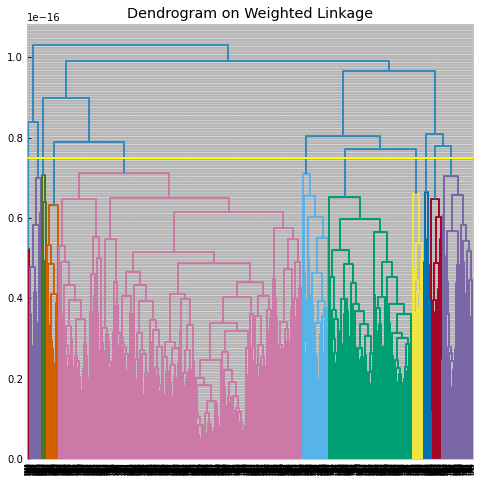

[ 1  2  3  4  5  6  7  8  9 10 11]


46.17149806022644

In [89]:
start_time = time.time()

plt.style.use("bmh")
plt.figure(figsize =(8, 8))
plt.title('Dendrogram on Weighted Linkage')
weighted_linkage = linkage(df_scaled, method ='weighted')
Dendrogram = dendrogram(weighted_linkage)

# specifying horizontal threshold line
plt.axhline(y=0.000000000000000075, color='yellow', linestyle='-')
plt.show()

# threshold appears to be 4 because the longest, thus an optimal number of clusters could be 7 clusters
labels = fcluster(weighted_linkage, t=0.000000000000000075,criterion='distance')
print(np.unique(labels))

end_time = time.time() - start_time
end_time


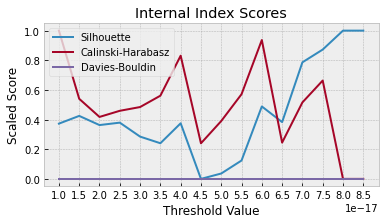

In [91]:
# no AgglomerativeClustering method for centroid

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

num_clusters = []
silhouette_coefficients = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

test_range = np.arange(0.00000000000000001,
                       0.00000000000000009, 0.000000000000000005)


centroid_linkage = linkage(df_scaled, method='centroid')

# instead, we will increase with threshold instead of num clusters
# Threshold is maximum inter-cluster distance allowed
for thresh in test_range:
    labels = fcluster(centroid_linkage, t=thresh, criterion='distance')
    ##Silhouette Score
    silhouette = silhouette_score(df_scaled, labels)
    silhouette_coefficients.append(silhouette)
    ##Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(df_scaled, labels)
    calinski_harabasz_scores.append(calinski_harabasz)
    ##Davies-Bouldin Score
    davies_bouldin = davies_bouldin_score(df_scaled, labels)
    davies_bouldin_scores.append(davies_bouldin)
    ##num clusters just in case
    num_clusters.append(np.unique(labels))


#scaled to same range to plot on a single graph
score_scaler = MinMaxScaler(feature_range=(0, 1))

silhouette_coefficients_scaled = score_scaler.fit_transform(
    np.array(silhouette_coefficients).reshape(-1, 1))
calinski_harabasz_scores_scaled = score_scaler.fit_transform(
    np.array(calinski_harabasz_scores).reshape(-1, 1))
davies_bouldin_scores_scaled = score_scaler.fit_transform(
    np.array(davies_bouldin_scores).reshape(-1, 1))

#plot all three
plt.figure(figsize=(6, 3))
plt.title("Internal Index Scores")
plt.plot(test_range, silhouette_coefficients_scaled, label='Silhouette')
plt.plot(test_range, calinski_harabasz_scores_scaled,
         label='Calinski-Harabasz')
plt.plot(test_range, davies_bouldin_scores_scaled, label='Davies-Bouldin')
plt.xticks(test_range)
plt.legend()
## if labelled, add a vertical line for the true number of clusters
plt.xlabel("Threshold Value")
plt.ylabel("Scaled Score")
plt.show()


## Analysis

In [104]:
WARD = AgglomerativeClustering(n_clusters=2, linkage="ward")
WARD.fit(df_scaled)
#WARD.labels_



C:\Users\mtfbw\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [131]:
trueLab = label_original.copy()
trueLab = pd.concat([trueLab, pd.Series(WARD.labels_)], axis=1)
trueLab.columns = ['true', 'ward']
s1 = trueLab[trueLab['ward']==0]
s2 = trueLab[trueLab['ward'] == 1]


In [133]:
s2.groupby('true').count()

,ward
true,
6,1
